In [1]:
# get_ipython().magic('matplotlib notebook')
get_ipython().magic('matplotlib inline')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import shapefile as shp
import numpy     as np
import xarray    as xr
import time      as clock

/albedo/home/pscholz/.conda/envs/py37/lib/python3.7/site-packages/xarray/core/options.py:93: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  FutureWarning,
/albedo/home/pscholz/.conda/envs/py37/lib/python3.7/site-packages/xarray/core/options.py:93: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  FutureWarning,


/albedo/home/pscholz/tripyview


In [2]:
# from dask.distributed import Client
# from dask.diagnostics import ProgressBar
# import dask

# n_workers=36
# tot_mem  = 250 # GB
# print(' --> memory_limit: {:3.3f} GB'.format(tot_mem/(n_workers+1)))
# dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
# client = Client(n_workers=n_workers, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(tot_mem/n_workers))
# client
# # client.shutdown

In [3]:
# Parameters
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= 5 #None #5 # set None --> take path as in input_paths otherwise add dir of cycle
which_mode= 'transect'

#_____________________________________________________________________________________
input_paths= list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/')

input_names= list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

vname     = 'vec+u+v'
year      = [1979, 2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/' # None
ref_name  = None #'TKE, ck=0.1' # None
ref_year  = None # [2009,2019]
ref_mon, ref_day, ref_record = None, None, None

#_____________________________________________________________________________________
input_transect = list()
input_transect.append([[-66, -66],[-67, -55], 'Drake Passage'])

# input_transect.append([[-56.5,-52.1,-49.8,-49.5,-49.0,-47.6,-45.7,-44.0,-42.8,-37.8,-35.2,-30.6,-27.9,-21.0,-12.3,-9.2,-4.0],
#                        [ 51.0, 52.7, 53.6, 55.0, 56.5, 59.0, 59.8, 60.4, 60.0, 59.6, 59.2, 58.9, 58.0, 58.0, 57.5,57.0,57.0], 
#                        'OSNAP'])

# input_transect.append([[-56.5,-52.1,-49.8,-49.5,-49.0,-47.6,-45.7,-44.0],
#                        [ 51.0, 52.7, 53.6, 55.0, 56.5, 59.0, 59.8, 60.4], 
#                        'OSNAP-West'])

# input_transect.append([[-44.0,-42.8,-37.8,-35.2,-30.6,-27.9,-21.0,-12.3,-9.2,-4.0],
#                        [ 60.4, 60.0, 59.6, 59.2, 58.9, 58.0, 58.0, 57.5,57.0,57.0], 
#                        'OSNAP-East'])

#_____________________________________________________________________________________
cstr      = 'blue2red'
cnum      = 20
cref      = 0
crange, cmin, cmax, cfac, climit = None, None, None, None, None
chist, ctresh = True, 0.995

#_____________________________________________________________________________________
ncolumn   = 3 
which_dpi = 300
do_rescale= None
do_ylog   = True
do_contour= False
do_allcycl= False
do_concat = False

In [5]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
if (which_cycl is not None) and (which_cycl is not "None"): 
    #__________________________________________________________________________________________________
    if do_allcycl: cycl_s=1
    else         : cycl_s=which_cycl    
    
    #__________________________________________________________________________________________________
    aux_path, aux_name = list(), list()
    input_paths_old, input_names_old = input_paths, input_names
    for ii, (ipath,iname) in enumerate(zip(input_paths,input_names)):
        for ii_cycl in range(cycl_s, which_cycl+1):
            # input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
            aux_path.append(os.path.join(ipath,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(iname))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, iname))
            print(ii, aux_path[-1],aux_name[-1])
    input_paths, input_names = aux_path, aux_name
    
    #__________________________________________________________________________________________________
    if (ref_path is not None) and (ref_path is not "None"): 
        aux_path, aux_name = list(), list()
        ref_path_old, ref_name_old = ref_path, ref_name
        for ii_cycl in range(cycl_s, which_cycl+1):
            #ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
            aux_path.append(os.path.join(ref_path,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(ref_name))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, ref_name))
            print('R', ref_path[-1])        
        ref_path, ref_name = aux_path, aux_name
    del(aux_path, aux_name)    
        
#______________________________________________________________________________________________________        
cinfo=dict({'cstr':cstr, 'cnum':cnum}) 
if crange   is not None: cinfo['crange']=crange
if cmin     is not None: cinfo['cmin'  ]=cmin
if cmax     is not None: cinfo['cmax'  ]=cmax
if cref     is not None: cinfo['cref'  ]=cref
if cfac     is not None: cinfo['cfac'  ]=cfac  
if climit   is not None: cinfo['climit']=climit  
if chist    is not None: cinfo['chist' ]=chist
if ctresh   is not None: cinfo['ctresh']=ctresh    
if ref_path is not None: cinfo['cref'  ]=0.0    
    
#______________________________________________________________________________________________________
# in case of diff plots
if (ref_path is not None) and (ref_path is not "None"): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record

#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if (ref_path is not None) and (ref_path is not "None"): 
    if isinstance(ref_path, list): 
        input_paths, input_names = ref_path + input_paths, ref_name + input_names
    else:    
        input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names        

 > found *.pckl file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node_focus0.pckl
___FESOM2 MESH INFO________________________
 > path            = /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________
0 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE


Drake Passage


/albedo/home/pscholz/.conda/envs/py37/lib/python3.7/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


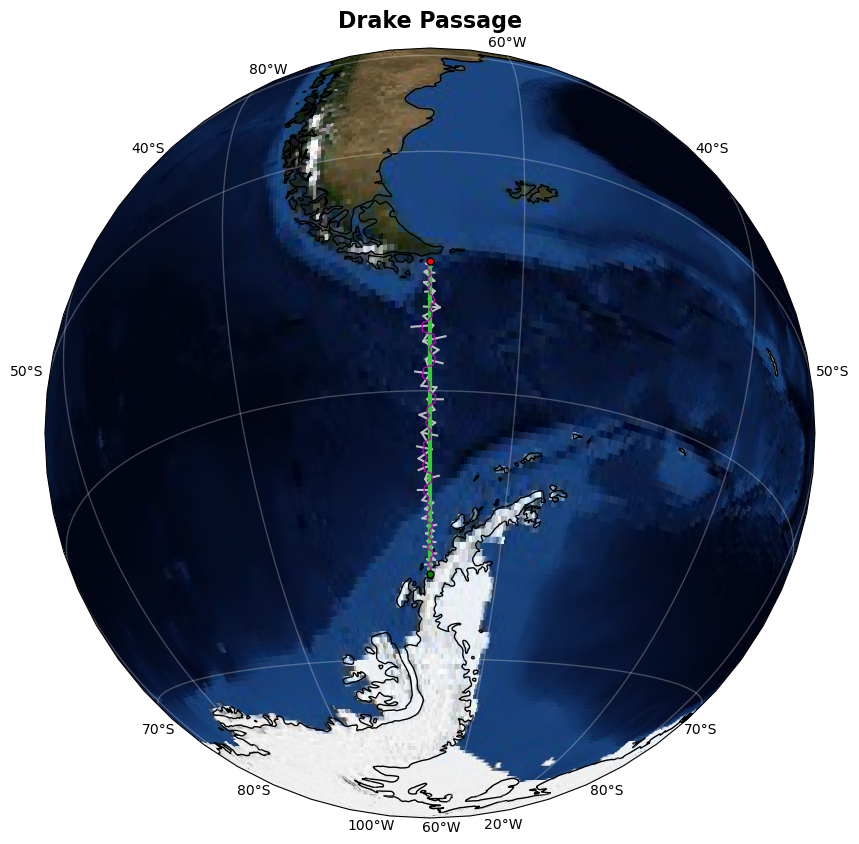

In [6]:
#______________________________________________________________________________________________________    
# load information about edges 
datapath = input_paths[0]
fname    = 'fesom.mesh.diag.nc'
# check for directory with diagnostic file
if   os.path.isfile( os.path.join(datapath, fname) ): 
    dname = datapath
elif os.path.isfile( os.path.join( os.path.join(os.path.dirname(os.path.normpath(datapath)),'1/'), fname) ): 
    dname = os.path.join(os.path.dirname(os.path.normpath(datapath)),'1/')
elif os.path.isfile( os.path.join(mesh.path,fname) ): 
    dname = mesh.path
else:
    raise ValueError('could not find directory with...mesh.diag.nc file')    
# load diag file
meshdiag   = xr.open_dataset(os.path.join(dname,fname))
# node indices of edge points [2 x n2ded]
edge       = meshdiag['edges'].values-1
# element indices of triangles that are left and right of edg: [2 x n2ded]
edge_tri   = meshdiag['edge_tri'].values-1
# dx & dy of edge midpoints towards element centroid of left and right triangle
edge_dxdy  = meshdiag['edge_cross_dxdy'].values[:]
# [L]eft  triangle: dx, dy
edge_dxdy_l= np.array([ edge_dxdy[0,:], edge_dxdy[1,:]])
# [R]ight triangle: dx, dy
edge_dxdy_r= np.array([ edge_dxdy[2,:], edge_dxdy[3,:]])
edge_dxdy_r[:, edge_tri[1,:]<0]=0. # if boundarie edge --> right triangle doesnot exist
del(edge_dxdy)

#______________________________________________________________________________________________________    
# analyse transects computes all neccesary arrays 
transects = tpv.do_analyse_transects(input_transect, mesh, edge, edge_tri, edge_dxdy_l, edge_dxdy_r)
for transect in transects:
    print(transect['Name'])
    fig, ax = tpv.plot_transect_position(mesh, transect, edge=edge, zoom=50)

In [8]:
tseries_list = list()
year_list    = list(range(year[0], year[1]+1))
chnk_size    = 10 # compute dmoc time-series in chunks of chnk_size years
chnk_yrs_list= year_list[::chnk_size]

#___LOAD FESOM2 DATA___________________________________________________________________________________
ts = clock.time()
for datapath, descript in zip(input_paths, input_names): 
    print(datapath, descript)
    print(' > year:', end='')
    
    # compute time series in chunk of year, to prevent matrices from becoming to big and you run out of memory !!!
    # you can play with chnk_size for the case you run out of memory 
    for nchnk, year_s in enumerate(chnk_yrs_list): 
        year_chnk = [ year_s, np.min([year_s+chnk_size-1,year[1]]) ]  
        print(*np.arange(year_chnk[0],year_chnk[1]+1), sep='|',end='\n        ')
        
        #____________________________________________________________________________________________________
        # load u and v data in rotated coordinates
        data  = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=year_chnk, mon=mon, descript=descript,
                                     do_vecrot=False, do_info=False, do_tarithm=None, do_zarithm='None', 
                                     do_ie2n=False, do_nan=False, do_compute=False, )#**{'chunks': {'nod2':1e4}})
        if data is None: break
        #____________________________________________________________________________________________________
        # compute transport through section 
        transp = tpv.calc_transect_transp(mesh, data, transects[0], do_info=False)
        del(data)
        
        #____________________________________________________________________________________________________
        # compute time-series
        transp  = transp.sum(dim=('npts','nz1'), skipna=True)
        if nchnk==0: transp_t = transp
        else       : transp_t = xr.concat([transp_t, transp], dim='time')
        
        #____________________________________________________________________________________________________
        del(transp)
    print('')    
    #____________________________________________________________________________________________________
    # moctseries_list.append([time, moc_t])    
    tseries_list.append(transp_t)    
print('        elapsed time: {:3.2f}min.'.format((clock.time()-ts)/60.0))

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE
 > year:1979|1980|1981|1982|1983|1984|1985|1986|1987|1988
        1989|1990|1991|1992|1993|1994|1995|1996|1997|1998
        1999|2000|2001|2002|2003|2004|2005|2006|2007|2008
        2009|2010|2011|2012|2013|2014|2015|2016|2017|2018
        2019
        
        elapsed time: 0.62min.


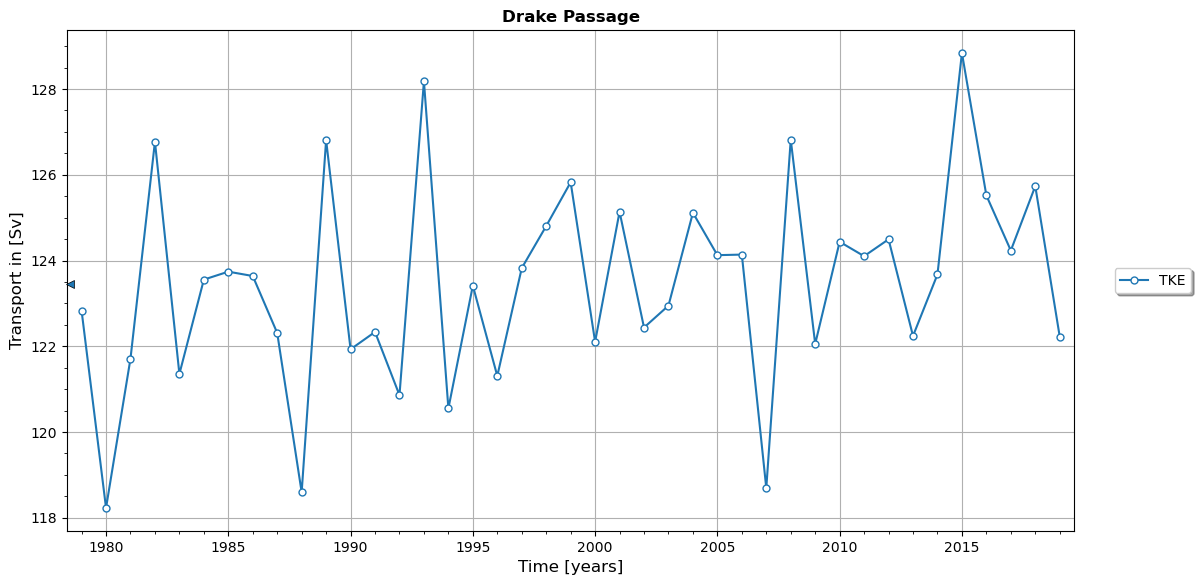

In [9]:
spath  = save_path
sname  = 'vflx'
slabel = transects[0]['Name'].replace(' ','_')
if spath is not None: spath  = os.path.join(spath,'{}_{}_{}_{}.png'.format(which_mode, sname, slabel, 'y:{:d}-{:d}'.format(year[0],year[1]) )) 
if save_fname is not None: spath = save_fname
    
fig,ax=tpv.plot_transect_transp_t(tseries_list, input_names, transects[0],  
                              which_cycl=which_cycl, do_allcycl=do_allcycl, do_concat=do_concat, 
                              do_save=spath, save_dpi=which_dpi, )  